# Siamese Neural Networks

The data must be images, in the form of (x_train, y_train), (x_val, y_val)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import pandas as pd
import os
import pickle
import random
from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Lambda, GlobalAvgPool2D, BatchNormalization, Dropout, LeakyReLU, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

## Auxiliary Functions

In [2]:
def normalize_images(images):
    return (images/255.0).astype('float32')

def augment_image(image):
    
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)
    
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,    # Random rotation
        width_shift_range=0.2,  # Horizontal shift
        height_shift_range=0.2,  # Vertical shift
        shear_range=0.2,  # Shear transformation
        zoom_range=0.2,  # Zoom in/out
        #horizontal_flip=True,  # Random horizontal flip -> Be careful with MNIST data
        fill_mode='nearest'  # Fill mode for new pixels
    )
    
    # Augment the image by randomly applying one of the above augmentations
    image = np.expand_dims(image, axis=0) 
    augmented_image = datagen.flow(image, batch_size=1)[0] 
    return augmented_image[0] 

def create_image_pairs(x, y, n_images=2, augment=True):
    pairs = []
    labels = []
    
    class_dict = {i: np.where(y == i)[0] for i in np.unique(y)}
    
    for class_label in np.unique(y):
        indices = class_dict[class_label]
        
        for idx in indices:
            # Create positive pairs
            for _ in range(n_images):
                idx2 = np.random.choice(indices, replace=False)
                img1, img2 = x[idx], x[idx2]
                
                if augment:
                    img1 = augment_image(img1)
                    img2 = augment_image(img2)
                
                pairs.append([img1, img2])
                labels.append(1) 
            
            # Create negative pairs
            for _ in range(n_images):
                neg_class = np.random.choice(np.delete(np.unique(y), class_label))
                idx2 = np.random.choice(class_dict[neg_class])
                img1, img2 = x[idx], x[idx2]
                
                if augment:
                    img1 = augment_image(img1)
                    img2 = augment_image(img2)
                
                pairs.append([img1, img2])
                labels.append(0)
    
    pairs = np.array(pairs)
    labels = np.array(labels)
    return pairs, labels

def create_image_pairs_unlabeled(x, n_images=2, augment=True):
    pairs = []
    labels = []
    
    num_images = len(x)
    
    for idx in range(num_images):
        img1 = np.expand_dims(x[idx], axis=-1) 
        
        for _ in range(n_images):
            img2 = augment_image(img1) if augment else img1
            pairs.append([img1, img2])
            labels.append(1)
        
        for _ in range(n_images):
            idx2 = np.random.randint(0, num_images)
            while idx2 == idx:
                idx2 = np.random.randint(0, num_images)
            img2 = np.expand_dims(x[idx2], axis=-1) 
            if augment:
                img2 = augment_image(img2)
            pairs.append([img1, img2])
            labels.append(0) 
    
    pairs = np.array(pairs)
    labels = np.array(labels)
    return pairs, labels

def plot_image_pairs(pairs, labels, num_samples=5):
    num_pairs = len(pairs)
    sampled_indices = np.random.choice(num_pairs, num_samples, replace=False)
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(6, num_samples*3))
    for i, idx in enumerate(sampled_indices):
        for j in range(2):
            img = pairs[idx][j]
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
        axes[i, 0].set_title(f'Label: {labels[idx]}')
    
    plt.show()

In [3]:
def reduce_dataset(x, y, samples_per_class=200):
    """Reduce the size of the dataset by sampling a fixed number of images per class."""
    reduced_x = []
    reduced_y = []
    
    for class_label in np.unique(y):
        class_indices = np.where(y == class_label)[0]
        sampled_indices = np.random.choice(class_indices, samples_per_class, replace=False)
        
        reduced_x.append(x[sampled_indices])
        reduced_y.append(y[sampled_indices])
    
    reduced_x = np.concatenate(reduced_x, axis=0)
    reduced_y = np.concatenate(reduced_y, axis=0)
    
    return reduced_x, reduced_y

In [4]:
def plot_random_images(images, labels, label_names, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        index = random.randint(0, len(images) - 1)
        img = images[index]
        label = labels[index]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(label_names[label].decode('utf-8'))
        plt.axis('off')
    plt.show()

In [5]:
def plot_random_images_without_names(images, labels, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        index = random.randint(0, len(images) - 1)
        img = images[index]
        label = labels[index]
        plt.subplot(1, num_images, i + 1)
        plt.title(f'Class: {label}')
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()

# Data

## MNIST DIGITS

In [6]:
(x_train, y_train), (x_val, y_val) = mnist.load_data()

In [7]:
x_train.shape

(60000, 28, 28)

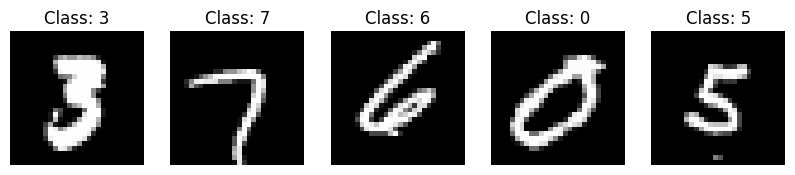

In [8]:
plot_random_images_without_names(x_train, y_train)

In [9]:
len(np.unique(y_train))

10

## MNIST FASHION

In [ ]:
train_df = pd.read_csv('../data/MNIST Fashion/fashion-mnist_train.csv')
test_df = pd.read_csv('../data/MNIST Fashion/fashion-mnist_test.csv')

In [ ]:
x_train = train_df.drop(columns=['label']).values
y_train = train_df['label'].values

x_val = test_df.drop(columns=['label']).values
y_val = test_df['label'].values

del(train_df)
del(test_df)

In [ ]:
x_train = x_train.reshape(-1, 28, 28)
x_val = x_val.reshape(-1, 28, 28)

In [ ]:
x_train = normalize_images(x_train)
x_val = normalize_images(x_val)

In [ ]:
plot_random_images_without_names(x_train, y_train)

In [ ]:
len(np.unique(y_train))

## MNIST CHINESE

In [12]:
csv_path = '../data/MNIST Chinese/chinese_mnist.csv'  
image_dir = '../data/MNIST Chinese/data/data/'  

In [13]:
df = pd.read_csv(csv_path)

df['filename'] = df.apply(lambda row: f"input_{row['suite_id']}_{row['sample_id']}_{row['code']}.jpg", axis=1)

image_data = []
for img_name in df['filename']:
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path).convert('L')
    img = np.array(img.resize((28, 28)))
    image_data.append(img)

x_train = np.array(image_data)
y_train = df['value'].values

x_train = normalize_images(x_train)

mapping = {100: 11, 1000: 12, 10000: 13, 100000000: 14}

y_train = np.array([mapping[label] if label in mapping else label for label in y_train])

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

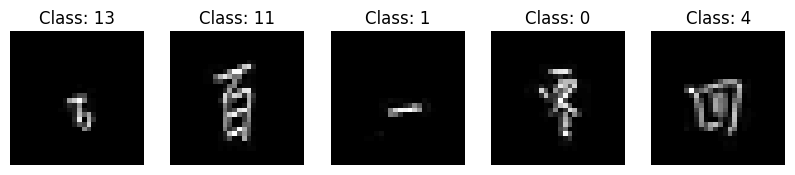

In [15]:
plot_random_images_without_names(x_train, y_train)

In [16]:
len(np.unique(y_train))

15

## MNIST HANDSIGNALS

In [139]:
train_df = pd.read_csv('../data/MNIST Handsignals/sign_mnist_train.csv')
test_df = pd.read_csv('../data/MNIST Handsignals/sign_mnist_test.csv')

x_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values

x_val = test_df.drop('label', axis=1).values
y_val = test_df['label'].values

x_train = x_train.reshape(-1, 28, 28)
x_val = x_val.reshape(-1, 28, 28)

mapping = {24: 9}

y_train = np.array([mapping[label] if label in mapping else label for label in y_train])
y_val = np.array([mapping[label] if label in mapping else label for label in y_val])

x_train = normalize_images(x_train)
x_val = normalize_images(x_val)

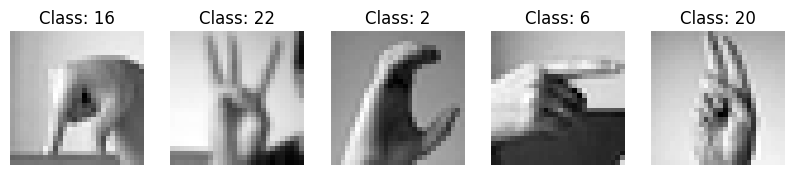

In [140]:
plot_random_images_without_names(x_train, y_train)

In [141]:
len(np.unique(y_train))

24

## CIFAR-10

In [195]:
def load_cifar10_batch(batch_file):
    with open(batch_file, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        images = batch[b'data']
        labels = batch[b'labels']
        images = images.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype('float32') / 255.0
        labels = np.array(labels)
        return images, labels

In [196]:
data_dir = '../data/CIFAR-10/cifar-10-batches-py'
train_images = []
train_labels = []

In [197]:
for i in range(1, 6):
    batch_file = os.path.join(data_dir, f'data_batch_{i}')
    images, labels = load_cifar10_batch(batch_file)
    train_images.append(images)
    train_labels.append(labels)

In [198]:
x_train = np.concatenate(train_images)
y_train = np.concatenate(train_labels)

In [199]:
x_val, y_val = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))

In [200]:
with open(os.path.join(data_dir, 'batches.meta'), 'rb') as f:
    label_meta = pickle.load(f, encoding='bytes')
    label_names = label_meta[b'label_names']

In [201]:
print(f'Training data shape: {x_train.shape}')
print(f'Validation data shape: {x_val.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Validation labels shape: {y_val.shape}')
print(f'Label names: {label_names}')

Training data shape: (50000, 32, 32, 3)
Validation data shape: (10000, 32, 32, 3)
Training labels shape: (50000,)
Validation labels shape: (10000,)
Label names: [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


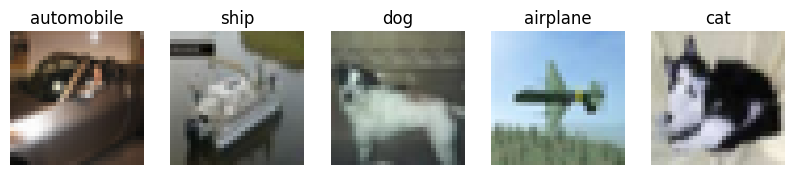

In [202]:
plot_random_images(x_train, y_train, label_names, num_images=5)

In [203]:
len(np.unique(y_train))

10

# Preprocessing and Modelling

In [10]:
reduced_x_train, reduced_y_train = reduce_dataset(x_train, y_train, samples_per_class=1)

#reduced_x_train = normalize_images(reduced_x_train)
#x_val = normalize_images(x_val)

In [11]:
reduced_x_train.shape

(10, 28, 28)

In [12]:
pd.DataFrame(reduced_y_train).value_counts()

0
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: count, dtype: int64

### Supervised Contrastive Learning

In [281]:
train_pairs, train_labels = create_image_pairs(reduced_x_train, reduced_y_train, n_images=30)

### Semi-supervised Contrastive Learning

In [ ]:
train_pairs, train_labels = create_image_pairs_unlabeled(reduced_x_train, n_images=30)

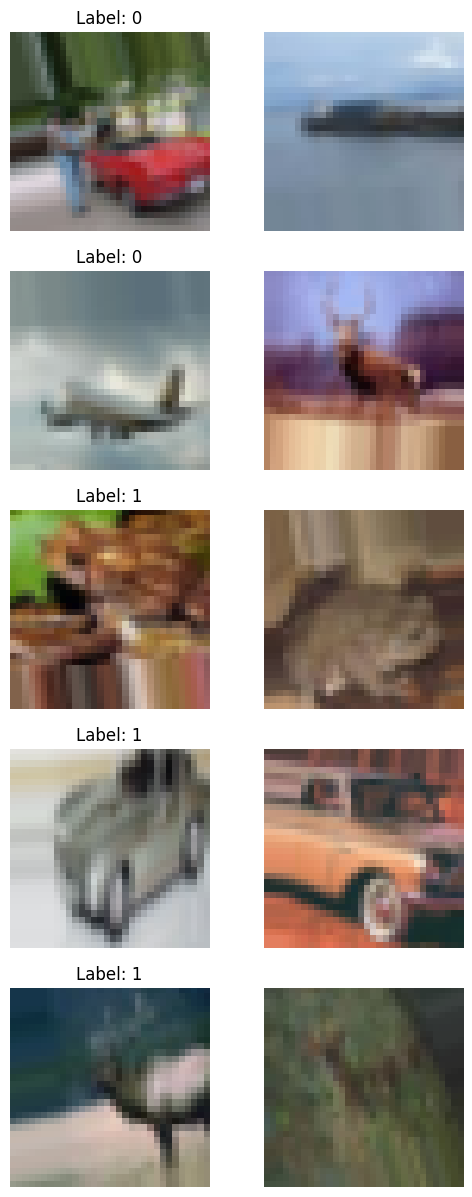

In [282]:
plot_image_pairs(train_pairs, train_labels)

In [283]:
train_pairs.shape

(30000, 2, 32, 32, 3)

# Benchmark Model

In [13]:
def benchmark_cnn_classifier(input_shape, num_classes):
    input_layer = Input(shape=input_shape, name='input_image')

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)  
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAvgPool2D()(x)
    x = Dense(512, activation='relu')(x)
    
    output_layer = Dense(num_classes, activation='softmax')(x)

    return Model(input_layer, output_layer, name='benchmark_cnn_classifier')

def more_complex_benchmark_cnn_classifier(input_shape, num_classes):
    input_layer = Input(shape=input_shape, name='input_image')

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAvgPool2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    output_layer = Dense(num_classes, activation='softmax')(x)

    return Model(input_layer, output_layer, name='more_complex_benchmark_cnn_classifier')

In [16]:
input_shape = (28, 28, 1)         #MNIST data
#input_shape = x_train.shape[1:]

num_classes = len(np.unique(reduced_y_train))

benchmark_model = benchmark_cnn_classifier(input_shape, num_classes)
#benchmark_model = more_complex_benchmark_cnn_classifier(input_shape, num_classes)
benchmark_model.summary()

Model: "benchmark_cnn_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,817,610 (6.93 MB)

 Trainable params: 1,817,610 (6.93 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
benchmark_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_labels_one_hot = to_categorical(reduced_y_train, num_classes)

history = benchmark_model.fit(
    reduced_x_train, train_labels_one_hot,
    epochs=30, 
    batch_size=32
)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step - accuracy: 0.1000 - loss: 11.8011
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1000 - loss: 26.3281
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2000 - loss: 35.4431
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1000 - loss: 39.0669
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4000 - loss: 25.2993
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3000 - loss: 17.1360
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3000 - loss: 10.4982
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2000 - loss: 6.1662
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4000 - loss: 3.6427
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5000 - loss: 2.5779
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3000 - loss: 2.0850
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4000 - loss: 

In [18]:
val_predictions_prob = benchmark_model.predict(x_val)

val_predictions = np.argmax(val_predictions_prob, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [19]:
accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation Accuracy: {accuracy:.4f}')

Validation Accuracy: 0.4392


In [20]:
class_report = classification_report(y_val, val_predictions)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.58      0.60       980
           1       0.92      0.74      0.82      1135
           2       0.54      0.24      0.33      1032
           3       0.72      0.17      0.28      1010
           4       0.51      0.33      0.40       982
           5       0.08      0.07      0.07       892
           6       0.31      0.76      0.44       958
           7       0.71      0.50      0.59      1028
           8       0.30      0.65      0.41       974
           9       0.35      0.30      0.32      1009

    accuracy                           0.44     10000
   macro avg       0.51      0.43      0.43     10000
weighted avg       0.52      0.44      0.43     10000



# Siamese Neural Networks

### Model Architectures

In [290]:
def simple_embedding_model(input_shape, embedding_dim=128):
    input_layer = Input(shape=input_shape, name='input_image')
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(embedding_dim, activation='relu')(x)
    return Model(input_layer, x, name='simple_embedding_model')

def complex_embedding_model(input_shape, embedding_dim=256):
    input_layer = Input(shape=input_shape, name='input_image')
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(embedding_dim, activation='relu')(x)
    return Model(input_layer, x, name='complex_embedding_model')

def more_complex_embedding_model(input_shape, embedding_dim=512):
    input_layer = Input(shape=input_shape, name='input_image')
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(embedding_dim, activation='relu')(x)
    return Model(input_layer, x, name='more_complex_embedding_model')

def improved_embedding_model(input_shape, embedding_dim=512):
    input_layer = Input(shape=input_shape, name='input_image')

    x = Conv2D(64, (3, 3), padding='same', kernel_initializer=HeNormal())(input_layer)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same', kernel_initializer=HeNormal())(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same', kernel_initializer=HeNormal())(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), padding='same', kernel_initializer=HeNormal())(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAvgPool2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(embedding_dim, activation='relu')(x)
    
    return Model(input_layer, x, name='improved_embedding_model')

def powerful_embedding_model(input_shape, embedding_dim=512):
    input_layer = Input(shape=input_shape, name='input_image')

    x = Conv2D(64, (3, 3), padding='same', kernel_initializer=HeNormal(), kernel_regularizer=l2(1e-4))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same', kernel_initializer=HeNormal(), kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same', kernel_initializer=HeNormal(), kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    if x.shape[1] > 2 and x.shape[2] > 2:
        x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), padding='same', kernel_initializer=HeNormal(), kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    if x.shape[1] > 2 and x.shape[2] > 2: 
        x = MaxPooling2D((2, 2))(x)

    x = Conv2D(1024, (3, 3), padding='same', kernel_initializer=HeNormal(), kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = GlobalAvgPool2D()(x)
    x = Dropout(0.5)(x) 
    x = Dense(embedding_dim, activation='relu', kernel_regularizer=l2(1e-4))(x)

    return Model(input_layer, x, name='powerful_embedding_model')

def pretrained_embedding_model(input_shape, embedding_dim=256):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model to use its pretrained weights
    
    input_layer = Input(shape=input_shape, name='input_image')
    x = base_model(input_layer)
    x = GlobalAvgPool2D()(x)
    x = Dense(embedding_dim, activation='relu', kernel_regularizer=l2(0.001))(x)
    return Model(input_layer, x, name='pretrained_embedding_model')

### Loss functions

#### Contrastive Loss -> Distance

In [291]:
def contrastive_loss(margin=1.0):
    def loss(y_true, y_pred):
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)
    return loss

#### Contrastive Hinge Loss -> Binary Prediction

In [292]:
def contrastive_hinge_loss(margin=1.0):
    def loss(y_true, y_pred):
        return tf.reduce_mean(y_true * tf.square(tf.maximum(0., margin - y_pred)) + (1 - y_true) * tf.square(y_pred))
    return loss

#### Binary Cross Entropy Loss -> Binary Prediction

In [293]:
def binary_crossentropy_loss():
    return tf.keras.losses.BinaryCrossentropy()

### Distance Layers

In [294]:
def euclidean_distance(embeddings):
    return tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[1]), axis=1) + tf.keras.backend.epsilon())

def cosine_similarity(embeddings):
    return 1 - tf.keras.losses.cosine_similarity(embeddings[0], embeddings[1])

Added the epsilon since very small square roots will result in Nan values, which will result in Nan values for the loss function.

## Siamese Model

In [295]:
def create_siamese_network(input_shape, embedding_model_func, distance_func, embedding_dim=128):
    embedding_model = embedding_model_func(input_shape, embedding_dim)
    
    input_a = Input(shape=input_shape, name='input_a')
    input_b = Input(shape=input_shape, name='input_b')
    
    processed_a = embedding_model(input_a)
    processed_b = embedding_model(input_b)
    
    # If using contrastive loss -> takes the distance as input:
    distance = Lambda(distance_func, name='distance_layer')([processed_a, processed_b])
    siamese_network = Model(inputs=[input_a, input_b], outputs=distance)
    
    # If using loss where embeddings required -> takes in embeddings as input
    #siamese_network = Model(inputs=[input_a, input_b], outputs=[processed_a, processed_b])
    
    # If using Cross entropy loss -> requires a prediction of 0 or 1
    #distance = Lambda(distance_func, name='distance_layer')([processed_a, processed_b])
    #reshaped_distance = Reshape((1,))(distance)
    #similarity_score = Dense(1, activation='sigmoid', name='similarity')(reshaped_distance)
    #siamese_network = Model(inputs=[input_a, input_b], outputs=similarity_score)
    
    return siamese_network, embedding_model

In [296]:
train_pairs[0][0].shape

(32, 32, 3)

In [311]:
#input_shape = (28, 28, 1)       #MNIST Data
input_shape = train_pairs[0][0].shape

embedding_dim = 256

siamese_network, embedding_model = create_siamese_network(input_shape, 
                                                          more_complex_embedding_model, 
                                                          euclidean_distance, 
                                                          embedding_dim)

In [312]:
embedding_model.summary()

Model: "more_complex_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │       131,328 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,682,304 (6.42 MB)

 Trainable params: 1,682,304 (6.42 MB)

 Non-trainable params: 0 (0.00 B)

In [313]:
siamese_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipvalue=1.0), 
                        loss=contrastive_loss())

train_pairs, val_pairs, train_labels, val_labels = train_test_split(train_pairs, train_labels, test_size=0.1, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = siamese_network.fit(
    [train_pairs[:, 0], train_pairs[:, 1]], train_labels,
    validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_labels),
    callbacks=[early_stopping],
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 60s 78ms/step - loss: 0.2658 - val_loss: 0.2159
Epoch 2/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 59s 78ms/step - loss: 0.2291 - val_loss: 0.2033
Epoch 3/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 57s 75ms/step - loss: 0.2162 - val_loss: 0.2035
Epoch 4/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 58s 77ms/step - loss: 0.2006 - val_loss: 0.1879
Epoch 5/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 57s 75ms/step - loss: 0.1799 - val_loss: 0.1689
Epoch 6/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 58s 76ms/step - loss: 0.1543 - val_loss: 0.1478
Epoch 7/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 58s 77ms/step - loss: 0.1293 - val_loss: 0.1316
Epoch 8/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 58s 77ms/step - loss: 0.1038 - val_loss: 0.1177
Epoch 9/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 57s 74ms/step - loss: 0.0789 - val_loss: 0.0983
Epoch 10/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 57s 74ms/step - loss: 0.0632 - val_loss: 0.0891
Epoch 11/100
760/760 ━━━━━━━━━━━━━━━━━━━━ 57s 75ms/step - loss: 0.0471 - val_loss: 0.0762
Epoch 12/100
760/76

In [ ]:
embedding_model.save('models/Siamese-CIFAR-more_complex/embedding_model.keras')

In [ ]:
embedding_model = load_model('models/Siamese-CIFAR-more_complex/embedding_model.keras')

In [314]:
embedding_model.summary()

Model: "more_complex_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │       131,328 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,682,304 (6.42 MB)

 Trainable params: 1,682,304 (6.42 MB)

 Non-trainable params: 0 (0.00 B)

### Visualising Embeddings

#### Training Images

In [315]:
reduced_x_train.shape

(500, 32, 32, 3)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


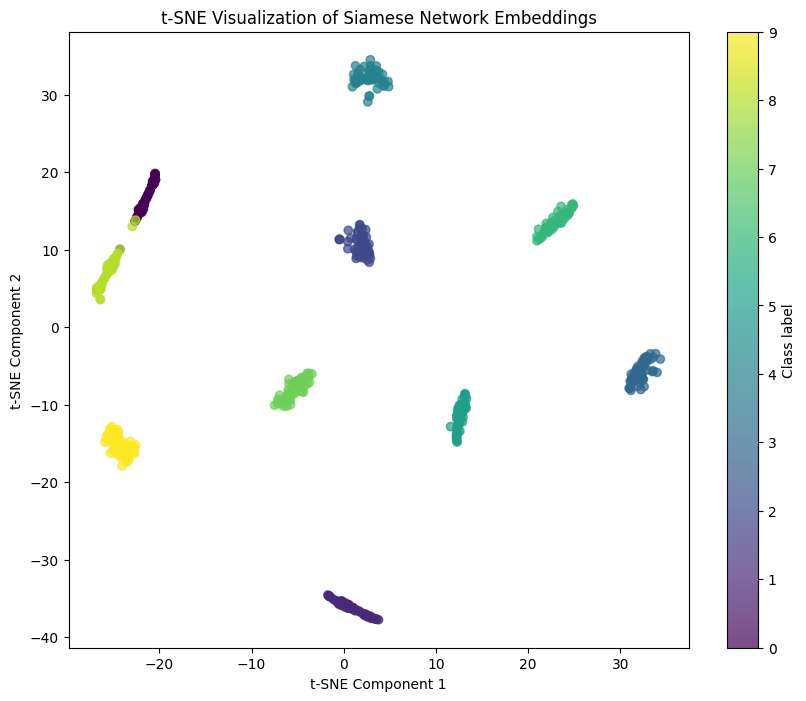

In [316]:
train_embeddings = embedding_model.predict(reduced_x_train)

tsne = TSNE(n_components=2, random_state=42)
train_embeddings_2d = tsne.fit_transform(train_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_embeddings_2d[:, 0], train_embeddings_2d[:, 1], c=reduced_y_train, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class label')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Siamese Network Embeddings')
plt.show()

#### Validation Images

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


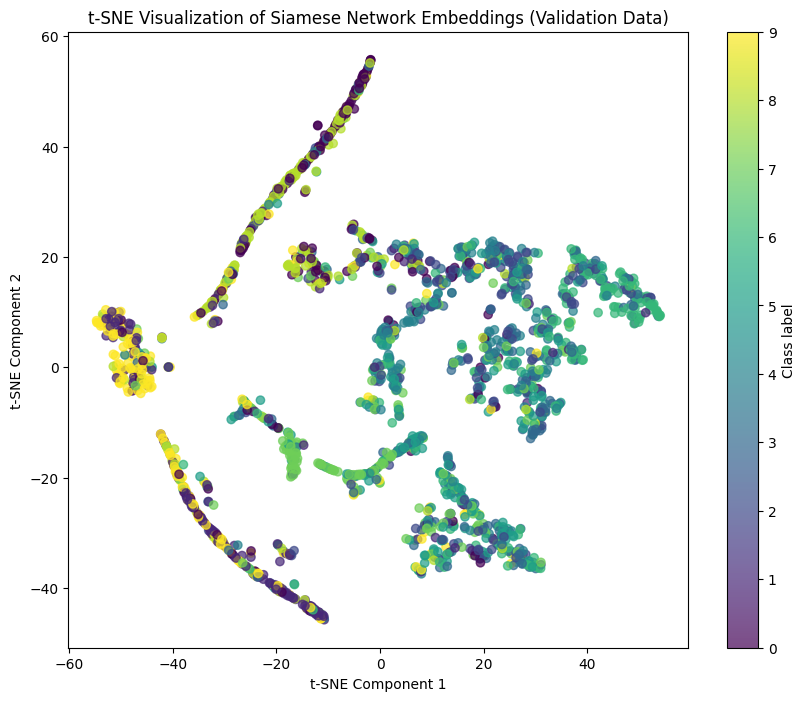

In [317]:
np.random.seed(42)
sample_indices = np.random.choice(x_val.shape[0], size=2000, replace=False)
x_val_sampled = x_val[sample_indices]
y_val_sampled = y_val[sample_indices]

val_embeddings = embedding_model.predict(x_val_sampled)

tsne = TSNE(n_components=2, random_state=42)
val_embeddings_2d = tsne.fit_transform(val_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(val_embeddings_2d[:, 0], val_embeddings_2d[:, 1], c=y_val_sampled, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class label')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Siamese Network Embeddings (Validation Data)')
plt.show()

## Predictive Model -> KNN

In [318]:
train_embeddings.shape

(500, 256)

In [319]:
knn = KNeighborsClassifier(n_neighbors=5)

In [320]:
knn.fit(train_embeddings, reduced_y_train)

KNeighborsClassifier()

In [321]:
val_embeddings = embedding_model.predict(x_val)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


In [322]:
y_pred = knn.predict(val_embeddings)

In [323]:
print(accuracy_score(y_val, y_pred))

0.382


In [324]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.21      0.32      1000
           1       0.45      0.49      0.47      1000
           2       0.22      0.51      0.31      1000
           3       0.27      0.31      0.28      1000
           4       0.40      0.20      0.26      1000
           5       0.32      0.26      0.28      1000
           6       0.66      0.33      0.44      1000
           7       0.56      0.35      0.43      1000
           8       0.43      0.58      0.49      1000
           9       0.44      0.60      0.51      1000

    accuracy                           0.38     10000
   macro avg       0.44      0.38      0.38     10000
weighted avg       0.44      0.38      0.38     10000



## Transfer Learning

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
def build_transfer_learning_model(embedding_model, num_classes):
    # Freeze the weights of the embedding model
    embedding_model.trainable = False
    
    input_layer = embedding_model.input
    x = embedding_model.output
    x = Dense(128, activation='relu')(x)  
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x) 
    
    transfer_model = Model(inputs=input_layer, outputs=output_layer)
    return transfer_model

In [ ]:
input_shape = (28, 28, 1)         #MNIST data
#input_shape = x_train.shape[1:]

num_classes = len(np.unique(y_train))

train_labels_one_hot = to_categorical(y_train, num_classes)
val_labels_one_hot = to_categorical(y_val, num_classes)

In [ ]:
transfer_model = build_transfer_learning_model(embedding_model, num_classes)

In [ ]:
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = transfer_model.fit(X_train, train_labels_one_hot, validation_data=(X_val, val_labels_one_hot),
                             epochs=100, batch_size=32, callbacks=[early_stopping])

# SimCLR

### Data Handling

In [186]:
def augment_image(image, original_size):
    if len(image.shape) == 2:  
        image = tf.expand_dims(image, axis=-1)

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)

    if original_size[0] > 28 and original_size[1] > 28:
        crop_height = min(int(0.9 * original_size[0]), original_size[0])
        crop_width = min(int(0.9 * original_size[1]), original_size[1])

        if crop_height < original_size[0] and crop_width < original_size[1]:
            image = tf.image.random_crop(image, size=(crop_height, crop_width, original_size[-1]))

    image = tf.image.resize(image, original_size[:2])

    return image

In [187]:
def create_image_pairs_unlabeled(x, n_images=2, augment=True):
    pairs = []
    
    original_size = x[0].shape  

    for idx in range(len(x)):
        img1 = x[idx]
        if len(img1.shape) == 2:  
            img1 = np.expand_dims(img1, axis=-1)

        for _ in range(n_images):
            img2 = augment_image(img1, original_size) if augment else img1
            img2 = np.expand_dims(img2, axis=-1) if len(img2.shape) == 2 else img2 

            pairs.append([img1, img2])

    return np.array(pairs)

### Base encoder and projection head

In [188]:
def build_encoder(input_shape, embedding_dim=128):
    inputs = Input(shape=input_shape)
    
    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = GlobalAveragePooling2D()(x)
    
    embedding = Dense(embedding_dim, activation=None)(x)
    return Model(inputs, embedding)

def build_complex_encoder(input_shape, embedding_dim=128):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    
    x = GlobalAveragePooling2D()(x)
    
    embedding = Dense(embedding_dim, activation=None)(x)
    
    return Model(inputs, embedding)

def more_complex_embedding_model(input_shape, embedding_dim=512):
    input_layer = Input(shape=input_shape, name='input_image')
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(embedding_dim, activation=None)(x)
    return Model(input_layer, x, name='more_complex_embedding_model')

In [189]:
def build_projection_head(embedding_dim, projection_dim=128):
    inputs = Input(shape=(embedding_dim,))
    x = Dense(projection_dim, activation='relu')(inputs)
    outputs = Dense(projection_dim)(x)
    return Model(inputs, outputs)

### NT-Xent Loss function

In [190]:
def nt_xent_loss(temperature=0.5):
    def loss(y_true, embeddings):  
        batch_size = tf.shape(embeddings)[0] // 2
        z_i, z_j = tf.split(embeddings, num_or_size_splits=2, axis=0)

        z_i = tf.math.l2_normalize(z_i, axis=1)
        z_j = tf.math.l2_normalize(z_j, axis=1)

        similarity_matrix = tf.matmul(z_i, z_j, transpose_b=True) / temperature

        sim_ij = tf.linalg.diag_part(similarity_matrix)

        exp_sim = tf.exp(similarity_matrix)
        exp_sim_sum = tf.reduce_sum(exp_sim, axis=1)

        loss_val = -tf.reduce_mean(tf.math.log(sim_ij / exp_sim_sum))
        return loss_val
    return loss

### Training

In [191]:
def simclr_model(input_shape, embedding_dim, projection_dim):
    encoder = more_complex_embedding_model(input_shape, embedding_dim)
    projection_head = build_projection_head(embedding_dim, projection_dim)

    inputs = Input(shape=input_shape)
    embeddings = encoder(inputs)
    projections = projection_head(embeddings)

    simclr_net = Model(inputs, projections)
    
    return simclr_net, encoder 

input_shape = (28, 28, 1) 
#input_shape = reduced_x_train.shape[1:]
embedding_dim = 256
projection_dim = 128

simclr_net, embedding_model = simclr_model(input_shape, embedding_dim, projection_dim)
simclr_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=nt_xent_loss())

In [192]:
train_pairs = create_image_pairs_unlabeled(reduced_x_train, n_images=10)
train_pairs.shape

(12000, 2, 28, 28, 1)

In [193]:
train_images = np.concatenate([train_pairs[:, 0], train_pairs[:, 1]], axis=0)

dummy_labels = np.zeros((train_images.shape[0],))

history = simclr_net.fit(train_images, dummy_labels, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 3.9857
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 3.8815
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 3.8591
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 3.8569
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 3.8478
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 3.8415
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 3.8370
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 3.8355
Epoch 9/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 3.8427
Epoch 10/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - loss: 3.8312
Epoch 11/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - loss: 3.8274
Epoch 12/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 3.8319
Epoch 13/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 3.8270
Epoch 14/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 3.8306
Epoch 15/50
750/750 ━━━━━━━━━

### Visualising embeddings

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


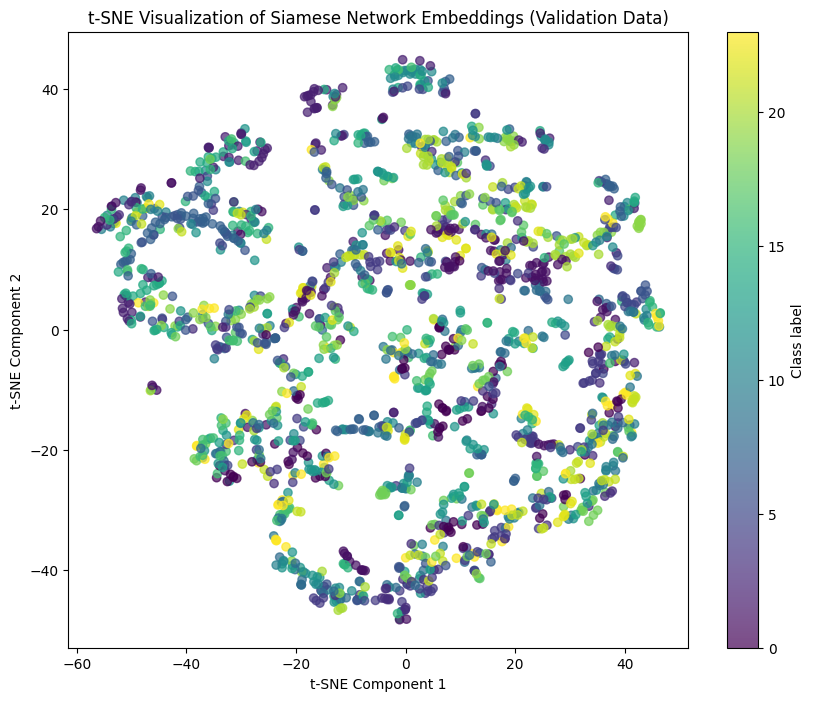

In [194]:
np.random.seed(42)
sample_indices = np.random.choice(x_val.shape[0], size=2000, replace=False)
x_val_sampled = x_val[sample_indices]
y_val_sampled = y_val[sample_indices]

val_embeddings = embedding_model.predict(x_val_sampled)

tsne = TSNE(n_components=2, random_state=42)
val_embeddings_2d = tsne.fit_transform(val_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(val_embeddings_2d[:, 0], val_embeddings_2d[:, 1], c=y_val_sampled, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class label')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Siamese Network Embeddings (Validation Data)')
plt.show()